In [1]:

import pandas as pd
import numpy as np
from shapely.geometry import box
from skysurvey import Survey
from skysurvey.tools.utils import get_skynoise_from_maglimit
from skysurvey.target import SNeIa
from shapely.ops import unary_union
from skysurvey.effects import mw_extinction
import matplotlib.pyplot as plt


In [2]:
parquet_path = "dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet"
df = pd.read_parquet(parquet_path)

In [3]:
df.head

<bound method NDFrame.head of               visit         ra        dec band           mjd  \
0     2024110800245  53.327236 -28.072055    i  60623.258521   
1     2024110800246  53.327425 -28.072347    r  60623.259329   
2     2024110800247  53.141378 -28.131211    r  60623.259895   
3     2024110800248  53.141304 -28.131213    i  60623.260739   
4     2024110800249  53.188483 -28.208666    i  60623.261307   
...             ...        ...        ...  ...           ...   
1323  2024121000482  59.344721 -48.732348    g  60655.278624   
1324  2024121000483  59.351742 -48.725014    g  60655.279019   
1325  2024121000484  59.137650 -48.766580    g  60655.279414   
1326  2024121000485  59.004105 -48.754548    g  60655.279809   
1327  2024121000486  59.225872 -48.752521    r  60655.280532   

      limitingMagnitude    seeing  
0               24.2174  0.844020  
1               24.6158  0.903278  
2               24.6542  0.871491  
3               24.2033  0.828322  
4               24.16

In [4]:
get_skynoise_from_maglimit

<function skysurvey.tools.utils.get_skynoise_from_maglimit(maglim, zp=30)>

In [5]:
df["limitingMagnitude"].apply(get_skynoise_from_maglimit,zp=30)

0        41.121599
1        28.491151
2        27.501096
3        41.659111
4        43.330130
           ...    
1323     33.768362
1324     33.335732
1325     50.604600
1326     46.621903
1327    133.189502
Name: limitingMagnitude, Length: 1328, dtype: float64

In [6]:
simdata = pd.DataFrame({
    "skynoise": df["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=30).values,
    "mjd": df["mjd"].values,
    "band": "lsst" + df["band"].values,
    "gain": 1.0,
    "zp": 30,
    "ra": df["ra"].values,
    "dec": df["dec"].values
}, index=df.index)

In [7]:
fov_deg = 40.0 / 60.0
half_size = fov_deg / 2.0
footprint = box(-half_size, -half_size, half_size, half_size)

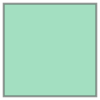

In [8]:
footprint

In [9]:
sur = Survey.from_pointings(simdata, footprint=footprint)

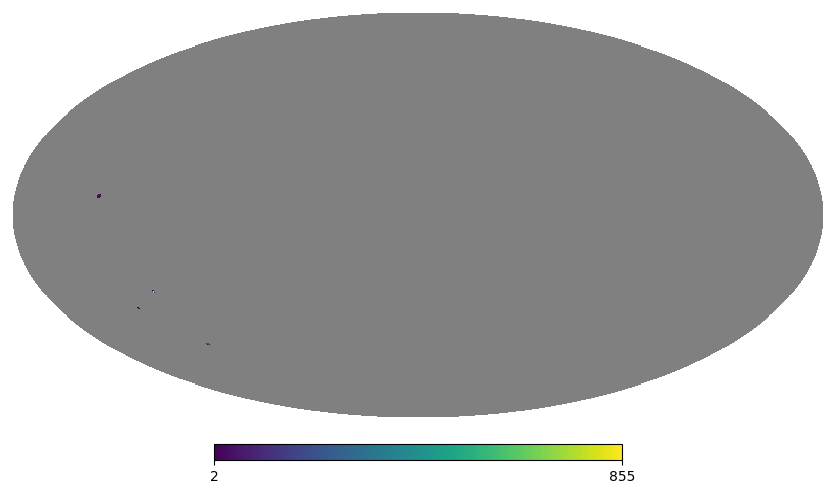

In [10]:
sur.show()

In [11]:
sur.data

,skynoise,mjd,band,gain,zp,ra,dec,fieldid_survey,fieldid
1283,28.491152,60623.257812,lsstr,1.0,30,53.327423,-28.072346,1,351881
1335,41.121597,60623.257812,lssti,1.0,30,53.327236,-28.072054,0,351881
1970,41.121597,60623.257812,lssti,1.0,30,53.327236,-28.072054,0,352681
1971,28.491152,60623.257812,lsstr,1.0,30,53.327423,-28.072346,1,352681
3048,28.491152,60623.257812,lsstr,1.0,30,53.327423,-28.072346,1,352682
...,...,...,...,...,...,...,...,...,...
6601,50.604599,60655.28125,lsstg,1.0,30,59.13765,-48.766579,1325,420718
6604,46.621902,60655.28125,lsstg,1.0,30,59.004105,-48.754547,1326,420718
6687,133.189499,60655.28125,lsstr,1.0,30,59.225872,-48.752522,1327,420719
6860,50.604599,60655.28125,lsstg,1.0,30,59.13765,-48.766579,1325,420719


In [12]:
tiles = []
for _, row in df.iterrows():
    ra = row["ra"]
    dec = row["dec"]
    tile = box(ra - half_size, dec - half_size, ra + half_size, dec + half_size)
    tiles.append(tile)
skyarea = unary_union(tiles)

# Time range of the survey
tstart, tstop = sur.get_timerange()

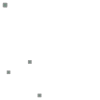

In [13]:
skyarea = unary_union(tiles)
skyarea

In [19]:
snia = SNeIa.from_draw(
    tstart=tstart,
    tstop=tstop,
    skyarea=skyarea,
    zmin=0.1,
    zmax=1.0,
    effect=mw_extinction,
    template='salt2-extended'
    )

In [20]:
print(snia.data)

          z            x1      c            t0         ra        dec  \
0   0.47005  5.800000e-01  0.058  60627.339844  58.844723 -49.091316   
1   0.82545 -1.095000e+00 -0.047  60649.113281  53.378460 -28.339727   
2   0.80635 -6.250000e-01 -0.079  60637.656250  37.187950   7.501449   
3   0.89565  1.090000e+00  0.088  60649.140625  58.640278 -49.022980   
4   0.65605  1.245000e+00 -0.125  60630.105469  59.045109 -49.132622   
5   0.88205  8.400000e-01 -0.104  60632.468750  40.518085 -34.378944   
6   0.65625  8.500000e-02  0.214  60648.613281  53.280445 -27.917011   
7   0.47835  3.750000e-01  0.624  60625.304688  59.527805 -49.019089   
8   0.97915 -6.150000e-01 -0.006  60638.464844  37.237579   7.047543   
9   0.74405 -2.425000e+00 -0.101  60653.984375  38.091293   6.818673   
10  0.25945 -7.750000e-01 -0.126  60629.117188  59.048656 -49.062153   
11  0.86485  8.450000e-01  0.125  60629.656250  40.363354 -34.734737   
12  0.65225 -1.255000e+00  0.033  60647.277344  53.436974 -27.95

In [21]:
from skysurvey import dataset
dset = dataset.DataSet.from_targets_and_survey(snia, sur,discard_bands=["lsstu"])
dset.data

/home/sushant/anaconda3/envs/rubin_sne/lib/python3.10/site-packages/skysurvey/dataset.py:681: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()


fieldid   band           mjd  zp zpsys  gain    skynoise  \
index index_obs                                                             
2     141         207116  lsstg  60641.070312  30    ab   1.0   29.246237   
      137         207116  lsstg  60643.089844  30    ab   1.0   29.419142   
      138         207116  lsstg  60643.089844  30    ab   1.0   28.815754   
      151         207116  lsstg   60643.09375  30    ab   1.0    27.89395   
      158         207116  lsstg  60652.089844  30    ab   1.0    47.39254   
...                  ...    ...           ...  ..   ...   ...         ...   
3     7024        420027  lsstz  60653.238281  30    ab   1.0   98.217751   
      7032        420027  lsstz  60653.238281  30    ab   1.0   97.380051   
      7034        420027  lsstz  60653.238281  30    ab   1.0  108.740166   
      7011        420027  lsstz  60653.242188  30    ab   1.0  112.561531   
      7054        420027  lsstz  60653.242188  30    ab   1.0  100.348297   

                       flux     fluxerr  
index index_obs                          
2     141        -21.968956   29.674758  
      137         65.125696   29.775999  
      138         10.281663   29.179991  
      151          2.909825   28.269907  
      158         59.159519   47.487729  
...                     ...         ...  
3     7024       182.067349   99.334295  
      7032       201.554460   98.506089  
      7034       136.806488  109.749712  
      7011        88.030265  113.537059  
      7054       231.436684  101.441339  

[5497 rows x 9 columns]

In [22]:
dset.obs_index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 21, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40,
       41, 42, 43, 44, 45, 47],
      dtype='int64', name='index')

In [25]:
dset.get_ndetection(per_band=True)

index  band 
0      lsstg     2
       lssti     7
       lsstr     9
       lsstz     8
1      lssti    81
                ..
44     lsstz    19
45     lsstr     1
47     lsstg     5
       lssti    12
       lsstr    25
Length: 93, dtype: int64

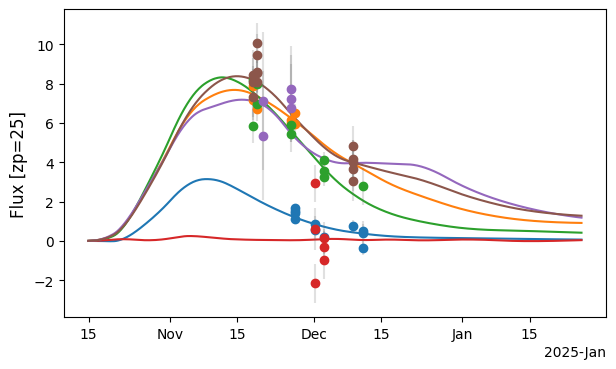

In [27]:
dset.show_target_lightcurve(index=0);

In [ ]:

detections = dset.get_data(detection=True, per_band=True)
detections.to_csv("test.csv")
print(np.unique(detections.index.get_level_values(0).to_numpy()))
len(np.unique(detections.index.get_level_values(0).to_numpy()))
# print(detections.fieldid.value_counts())


TypeError: DataSet.get_data() got an unexpected keyword argument 'per_band'

In [30]:
lc0 = dset.get_target_lightcurve(index=0)
print(lc0)

lc0['mjd_int'] = lc0['mjd'].astype(int)
lc0['variance'] = lc0['fluxerr']**2
lc0

           fieldid   band           mjd  zp zpsys  gain    skynoise  \
index_obs                                                             
7009        420027  lsstg  60641.101562  30    ab   1.0   25.512323   
7040        420027  lsstg  60641.101562  30    ab   1.0   33.179512   
7039        420027  lsstg  60641.113281  30    ab   1.0   19.087542   
7056        420027  lsstg  60641.113281  30    ab   1.0   19.550146   
7037        420027  lsstg  60645.140625  30    ab   1.0   38.398125   
7044        420027  lsstg   60645.15625  30    ab   1.0   44.005806   
7046        420027  lsstg     60647.125  30    ab   1.0   28.399454   
7053        420027  lsstg  60653.234375  30    ab   1.0    30.87948   
7026        420027  lsstg  60655.269531  30    ab   1.0    62.09119   
7041        420027  lsstg  60655.269531  30    ab   1.0   35.575417   
7052        420027  lsstg  60655.277344  30    ab   1.0   34.024361   
7036        420027  lssti  60632.238281  30    ab   1.0   78.204185   
7042  

,fieldid,band,mjd,zp,zpsys,gain,skynoise,flux,fluxerr,mjd_int,variance
index_obs,,,,,,,,,,,
7009,420027,lsstg,60641.101562,30,ab,1.0,25.512323,149.812840,27.751800,60641,770.162408
7040,420027,lsstg,60641.101562,30,ab,1.0,33.179512,143.647415,34.930842,60641,1220.163751
7039,420027,lsstg,60641.113281,30,ab,1.0,19.087542,166.096361,21.988829,60641,483.508589
7056,420027,lsstg,60641.113281,30,ab,1.0,19.550146,109.792966,22.391574,60641,501.382582
7037,420027,lsstg,60645.140625,30,ab,1.0,38.398125,84.875558,39.498445,60645,1560.127154
7044,420027,lsstg,60645.15625,30,ab,1.0,44.005806,53.723427,44.967847,60645,2022.107234
7046,420027,lsstg,60647.125,30,ab,1.0,28.399454,21.400072,29.640321,60647,878.548607
7053,420027,lsstg,60653.234375,30,ab,1.0,30.87948,73.604343,31.571748,60653,996.775295
7026,420027,lsstg,60655.269531,30,ab,1.0,62.09119,40.978010,62.387701,60655,3892.225269


In [31]:
lc0_g = lc0.groupby('mjd_int')[['flux', 'variance']].sum()

In [32]:
lc0_g

,flux,variance
mjd_int,,
60632,5291.832731,71291.351870
60633,6640.645649,62655.916389
60634,1248.753375,230756.950561
60640,4525.579253,156363.090349
60641,1815.706499,7858.018220
60645,275.909610,33746.047607
60647,1000.036727,29667.130690
60653,2040.354319,56683.651587
60655,330.899488,15340.417220


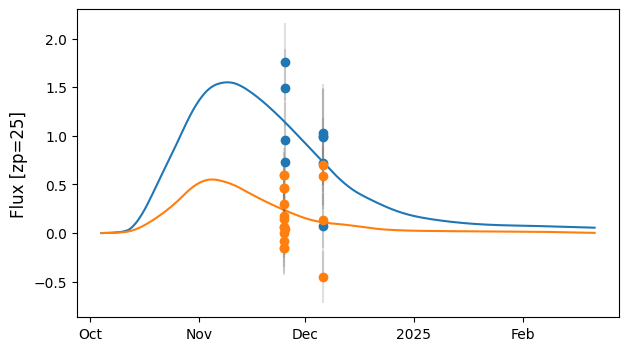

In [ ]:
fig = dset.show_target_lightcurve(index=25)
